In [1]:
import numpy as np
import grape as utils
from scipy.linalg import expm
import matplotlib.pyplot as plt
import copy
from scipy.optimize import minimize
from scipy.optimize import Bounds

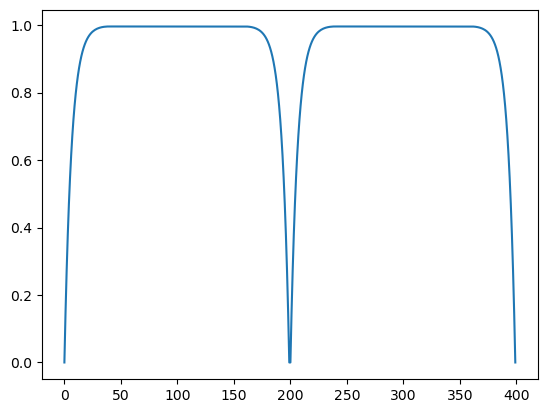

In [308]:
divn = int(np.floor(nsegments*(20/100)))
x = np.linspace(-2 * np.pi , 2 * np.pi, divn * 2); 
pcurve = (1 - np.cosh(x)/max(np.cosh(x))).tolist()
penalty_range = np.asarray(pcurve[0:divn] + (max(pcurve)*np.ones((nsegments- 2* divn ,))).tolist() + pcurve[divn:])
plt.plot(np.append(penalty_range,penalty_range))
penal = np.append(penalty_range,penalty_range)

In [314]:
nions=1
max_amp = 2 * np.pi * 25e3  
sx,sy,sz, ssx, ssy, ssz, Had = utils.get_spinops(nions,1/300)
utarg = expm(-1j * (np.pi / 2 ) * sx[0] / 2) 

tau = 50e-6
nsegments = 200
del_t = tau/nsegments 
# x0 = np.random.rand(nsegments*2);
# x0 = np.load('xinitial.npy')
x0 = result.x
# x0 = xsmooth
# x2 = np.load('x120s_optimized.npy'); 
# x0 = utils.smooth_pulse(x2,60,2)
# x0 = np.load('x30s_optimized.npy'); 
# x0 = np.asarray([-2.94650661e-01,  8.18969715e-01, -8.72864686e-01, -6.51449500e-01,
#         1.00000000e+00,  1.00000000e+00,  1.00000000e+00, -3.05380167e-06,
#        -1.00000000e+00, -1.00000000e+00]) # for no rfi, 5, 12e-6, fun 1.6681861447764845e-07
# x1 = np.repeat(x2,10)
# x0 = utils.smooth_pulse(x1,50,2)

# rfi=[1]+np.linspace(0,1/300,5).tolist()
# rfi=[1]
# rfi=[1.01,1.009,1.008,1.007,1.006,1.005,1.004,1.003,1.002,1.001,1,0.999,0.998,0.997,0.996,0.995,.994,0.993,0.992,0.991,0.990]
rfi=[1.002,1.001,1,0.999,0.998]
# rfi = np.linspace(0.98,1.02,25).tolist()
# rffull = np.linspace(0,1/300,25); rffull[0]=1
# rfi = rffull.tolist()
print(utils.calc_fidelity6_ct(x0, nsegments, rfi, ssx, ssy, utarg, del_t, nions, max_amp))
# bnd = Bounds(lb=-penal,ub=penal)
bnd = Bounds(lb=-np.ones(nsegments*2),ub=np.ones(nsegments*2))
result = minimize(utils.calc_fidelity6_ct,
         x0=x0,
         jac=utils.calc_grad2,
         args = (nsegments, rfi, ssx, ssy, utarg, del_t, nions, max_amp),
         method='L-BFGS-B',
         options={'disp':True, 'gtol':1e-16, 'ftol':1e-16},
         bounds=bnd,
        )
result
# np.save('xinitial.npy', result.x)

0.006109679817623004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          400     M =           10

At X0         4 variables are exactly at the bounds

At iterate    0    f=  6.10968D-03    |proj g|=  2.50871D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.006109679817623004
        x: [ 0.000e+00 -1.457e-01 ... -1.201e-01  0.000e+00]
      nit: 0
      jac: [-4.716e-11 -4.872e-11 ... -2.448e-10 -2.448e-10]
     nfev: 20
     njev: 20
 hess_inv: <400x400 LbfgsInvHessProduct with dtype=float64>

  400      1     21      1     0     4   2.509D-10   6.110D-03
  F =   6.1096798176230038E-003

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [246]:
# np.save('x_rfoptim_101_99_smooth_penal2.npy', result.x)

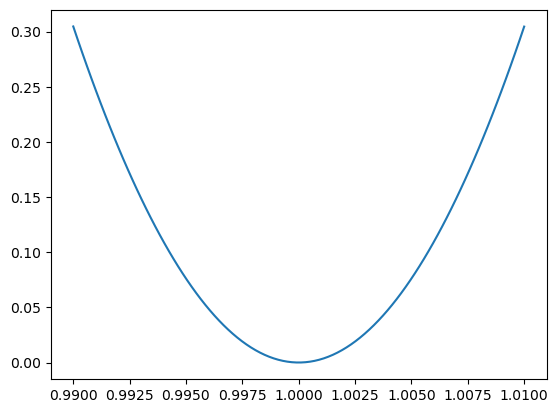

In [289]:
xx = np.load('xinitial.npy')
rfi_range = np.linspace(0.99,1.01,100)
infid2=[]
for rfiv in rfi_range:
    infid2.append(utils.calc_fidelity6_ct(xx, nsegments, [rfiv], ssx, ssy, utarg, del_t, nions, max_amp))

plt.plot(rfi_range,infid2)

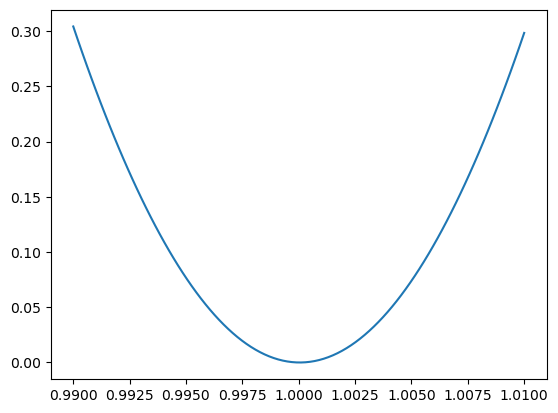

In [301]:
rfi_range = np.linspace(0.99,1.01,100)
infid=[]
for rfiv in rfi_range:
    infid.append(utils.calc_fidelity6_ct(result.x, nsegments, [rfiv], ssx, ssy, utarg, del_t, nions, max_amp))

plt.plot(rfi_range,infid)
# plt.plot(rfi_range,infid2)
# plt.yscale('log')

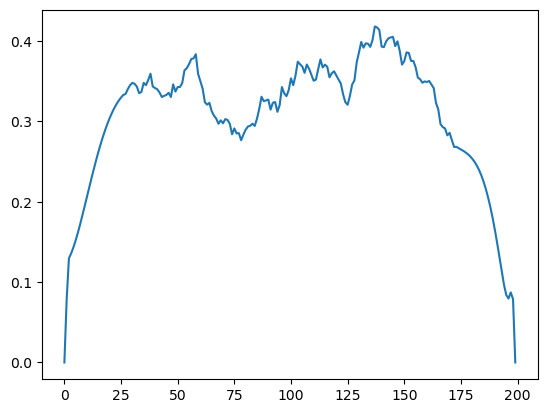

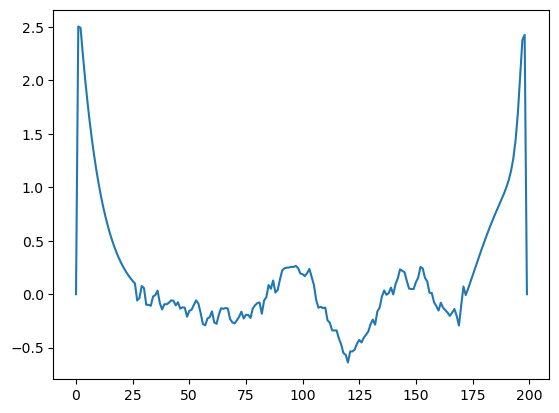

In [291]:
ux = result.x[0:nsegments]
uy = result.x[nsegments:]
amp = np.sqrt(ux**2 + uy**2)  
pha = np.arctan2(uy,ux)
plt.plot(amp)
plt.figure()
plt.plot(pha)

(400,)

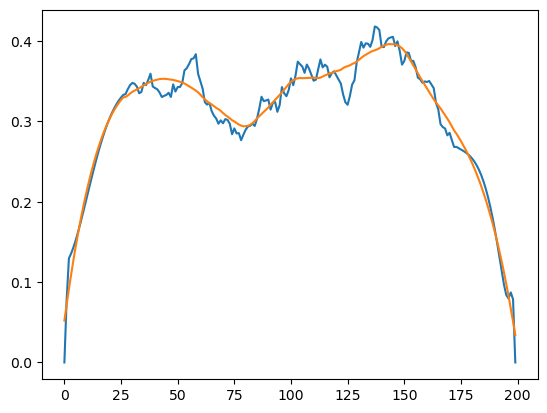

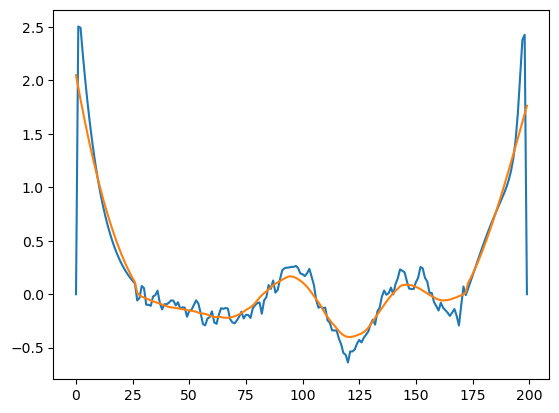

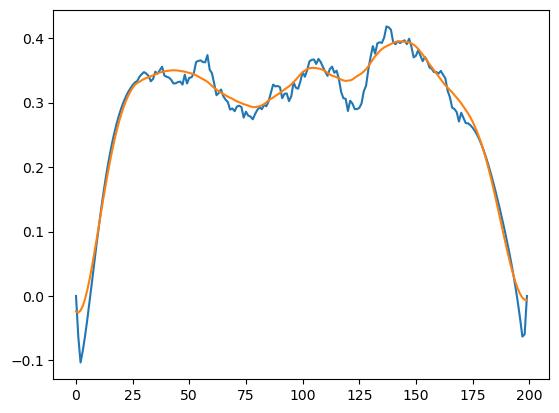

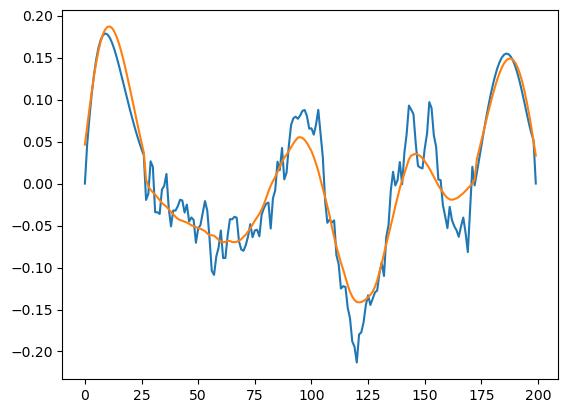

In [292]:
def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

from scipy import signal

ampp = signal.savgol_filter(amp,53,3)
phaa = signal.savgol_filter(pha,53,3)
# np.shape(ampp)
plt.plot(amp)
plt.plot(ampp)
plt.figure()
plt.plot(pha)
plt.plot(phaa)
uxx = ampp*np.cos(phaa)
uyy = ampp*np.sin(phaa)
plt.figure()
plt.plot(ux)
plt.plot(uxx)
plt.figure()
plt.plot(uy)
plt.plot(uyy)
xsmooth = np.append(uxx,uyy)
np.shape(xsmooth)

In [17]:
Uf = utils.calc_uf(result.x, nsegments, rfi, ssx, ssy, del_t,nions, max_amp)
Uf[0][-1]

array([[ 7.07106782e-01+1.70636726e-09j,  1.36089141e-09-7.07106781e-01j],
       [-1.36089141e-09-7.07106781e-01j,  7.07106782e-01-1.70636726e-09j]])

In [10]:
print(utils.calc_fidelity5(result.x , nsegments, np.asarray([[1,1]]) , ssx, ssy, utarg, del_t, nions, max_amp))
print(utils.calc_fidelity5(result.x*1/300 , nsegments, np.asarray([[1,1]]) , ssx, ssy, np.eye(2), del_t, nions, max_amp))


4.440892098500626e-12
0.03455750789527201


In [ ]:
nions=1
max_amp = 2 * np.pi * 25e3  
sx,sy,sz, ssx, ssy, ssz, Had = utils.get_spinops(nions,1/300)
utarg = expm(-1j * (np.pi / 2 ) * sx[0] / 2) 
rffull = np.linspace(0,1/300,100); rffull[0]=1

tau = 50e-6
nsegments = 200
del_t = tau/nsegments 

bnd = Bounds(lb=-np.ones(nsegments*2),ub=np.ones(nsegments*2))
numrfi_add = 2
for j in range(1,50):
        if j==1:
                # x0 = np.load('x120s_optimized.npy') 
                x0 = result.x 
        else:
                x0 = result.x
                
        rfi=rffull[0:numrfi_add*j+1].tolist()
        print(f"running for {j}")
        print(rfi)
        result = minimize(utils.calc_fidelity6_ct,
         x0=x0,
         jac=utils.calc_grad2,
         args = (nsegments, rfi, ssx, ssy, utarg, del_t, nions, max_amp),
         method='L-BFGS-B',
         options={'disp':True, 'gtol':1e-9},
         bounds=bnd,
        )
        result

In [79]:
# one point optimization
print(utils.calc_fidelity6_ct(result.x, nsegments, [1], ssx, ssy, utarg, del_t, nions, max_amp))
print(utils.calc_fidelity6_ct(result.x, nsegments, [1/300], ssx, ssy, utarg, del_t, nions, max_amp))

4.074430792755379e-06
0.08024798965222679


In [8]:
np.save('xoptimized.npy', result.x)

In [34]:
# two point optimization
# xx = np.load('xinitial.npy')
xx =result.x

print(utils.calc_fidelity6_ct(xx, nsegments, [1], ssx, ssy, utarg, del_t, nions, max_amp))
print(utils.calc_fidelity6_ct(xx, nsegments, [0.0033], ssx, ssy, utarg, del_t, nions, max_amp))

4.735022217289275
0.03134372425384058


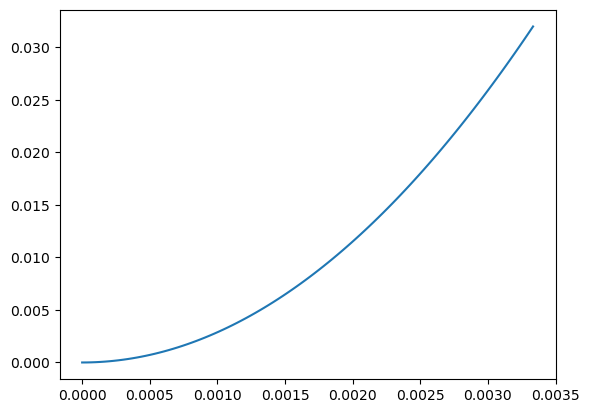

In [30]:
# xx = np.load('xoptimized.npy')
xx =result.x
cross_range = np.linspace(0,1/300,100)
infid=[]
for cross in cross_range:
    infid.append(utils.calc_fidelity6_ct(xx, nsegments, [cross], ssx, ssy, utarg, del_t, nions, max_amp))
    
plt.plot(cross_range,np.asarray(infid))

# xx = np.load('xinitial.npy')
# cross_range = np.linspace(0,1/300,100)
# infid=[]
# for cross in cross_range:
#     infid.append(utils.calc_fidelity6_ct(xx, nsegments, [cross], ssx, ssy, utarg, del_t, nions, max_amp))
    
# plt.plot(cross_range,np.asarray(infid))
# plt.yscale('log')

In [16]:
xx = np.load('x120s_optimized.npy')
print(utils.calc_fidelity6_ct(xx, nsegments, [1/300], ssx, ssy, utarg, del_t, nions, max_amp))


0.13166070319314827
